# GNN for Node Classification

## Installing Dependencies

In [ ]:
!python -c "import torch; print(torch.__version__)"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-geometric

## Importing Dependencies

In [ ]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import TUDataset
from torch_geometric.utils.convert import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

## Defining the GNN Model

In [ ]:
class CiteNet(torch.nn.Module):
    def __init__(self,gcns):
        super(CiteNet, self).__init__()
        self.module_list = torch.nn.ModuleList()
        for layer_id in range(len(gcns) - 1):
            self.module_list.append(GCNConv(gcns[layer_id], gcns[layer_id+1]))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for layer in self.module_list:
            x = layer(x, edge_index)
            x = F.relu(x)
        return F.log_softmax(x, dim=1)

## Import the Cora Dataset

In [ ]:
dataset = Planetoid(root = '/content/cora',name='Cora')

## Visualize the Cora Dataset

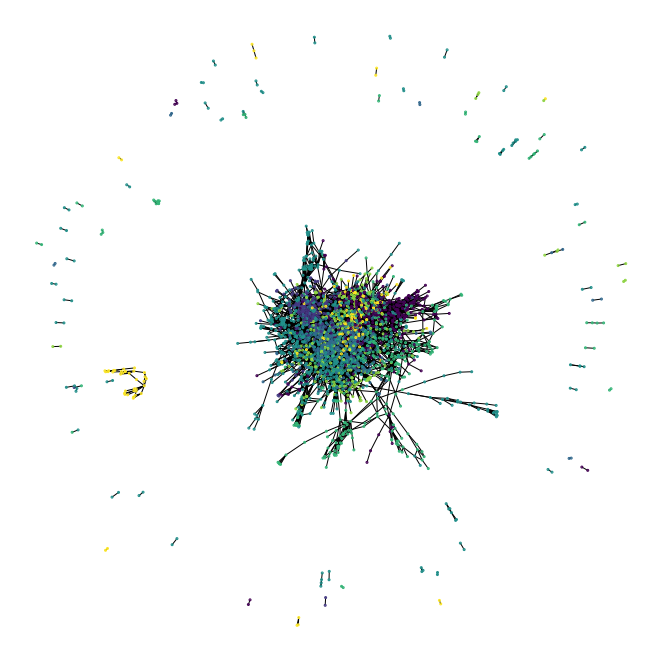

In [11]:
item = dataset[0]
itemx = to_networkx(item,to_undirected=True)
pos = nx.spring_layout(itemx)
true_labels = item.y.numpy()
plt.figure(figsize=(9,9))
nx.draw(itemx,pos=pos,node_color = true_labels,node_size=1,linewidths=2)
plt.show()

## Train the GNN

In [18]:
device = torch.device('cuda')
model_gallery = []
for i in range(2,2+25):
    depth = np.linspace(1433,7,i,dtype=int)
    model_gallery.append(CiteNet(depth).to(device))

data = dataset[0].to(device)
for model in model_gallery:
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    model.eval()

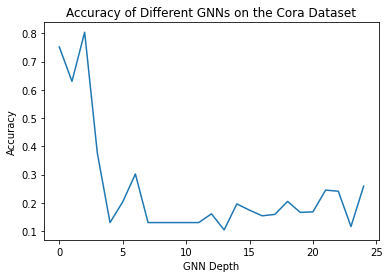

In [19]:
accuracies = []
for model in model_gallery:
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    accuracies.append(correct / int(data.test_mask.sum()))
plt.plot(accuracies)
plt.title('Accuracy of Different GNNs on the Cora Dataset')
plt.ylabel('Accuracy')
plt.xlabel('GNN Depth')
plt.show()